## Sales forecasting using SARIMA model

In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings('ignore')

C:\Users\sonal\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#read the various datasets available(train and test dataset)
df=pd.read_csv('train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
df.shape

(913000, 4)

In [4]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

There are no null values present

In [5]:
df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [6]:
#converting date column to datetime datatype
df['date']=pd.to_datetime(df['date'])

In [7]:
df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [8]:
#Create new columns based on date column
df['month'] = df['date'].apply(lambda x:x.month)
df['day_of_month'] = df['date'].apply(lambda x:x.day)
df['year'] = df['date'].apply(lambda x:x.year)

In [9]:
df.head()

,date,store,item,sales,month,day_of_month,year
0,2013-01-01,1,1,13,1,1,2013
1,2013-01-02,1,1,11,1,2,2013
2,2013-01-03,1,1,14,1,3,2013
3,2013-01-04,1,1,13,1,4,2013
4,2013-01-05,1,1,10,1,5,2013


In [10]:
df_monthly_sales=df.groupby(['item','store','year','month']).agg(total_sales=("sales", 'sum'))
df_monthly_sales = df_monthly_sales.reset_index()

In [11]:
df_monthly_sales.head()

,item,store,year,month,total_sales
0,1,1,2013,1,328
1,1,1,2013,2,322
2,1,1,2013,3,477
3,1,1,2013,4,522
4,1,1,2013,5,531


In [12]:
#number of unique stores
df['store'].nunique()

10

In [13]:
#number of unique items
df['item'].nunique()

50

In [14]:
df_monthly_sales['date'] = pd.to_datetime(df_monthly_sales['year'].astype(str) + '-' + df_monthly_sales['month'].astype(str) + '-' + '1')

In [15]:
df_monthly_sales.dtypes

item                    int64
store                   int64
year                    int64
month                   int64
total_sales             int64
date           datetime64[ns]
dtype: object

In [16]:
df_monthly_sales.head()

,item,store,year,month,total_sales,date
0,1,1,2013,1,328,2013-01-01
1,1,1,2013,2,322,2013-02-01
2,1,1,2013,3,477,2013-03-01
3,1,1,2013,4,522,2013-04-01
4,1,1,2013,5,531,2013-05-01


In [17]:
# grouping by average of sales across stores for each item
avg_monthly_sales=df_monthly_sales.groupby(['item','date']).agg(avg_sales=("total_sales", 'mean'))
avg_monthly_sales = avg_monthly_sales.reset_index()
avg_monthly_sales.head()

,item,date,avg_sales
0,1,2013-01-01,379.4
1,1,2013-02-01,386.3
2,1,2013-03-01,519.0
3,1,2013-04-01,578.3
4,1,2013-05-01,629.8


In [18]:
#choosing 6 products for sales forecasting
avg_monthly_sales_6_items=avg_monthly_sales.loc[avg_monthly_sales['item'].isin([1,2,3,9,5,8])]
avg_monthly_sales_6_items.head()

,item,date,avg_sales
0,1,2013-01-01,379.4
1,1,2013-02-01,386.3
2,1,2013-03-01,519.0
3,1,2013-04-01,578.3
4,1,2013-05-01,629.8


#### Average sales pattern for 6 items from 2013 to 2017

Text(0.5, 1.0, 'Average monthly sales time series chart for 6 items')

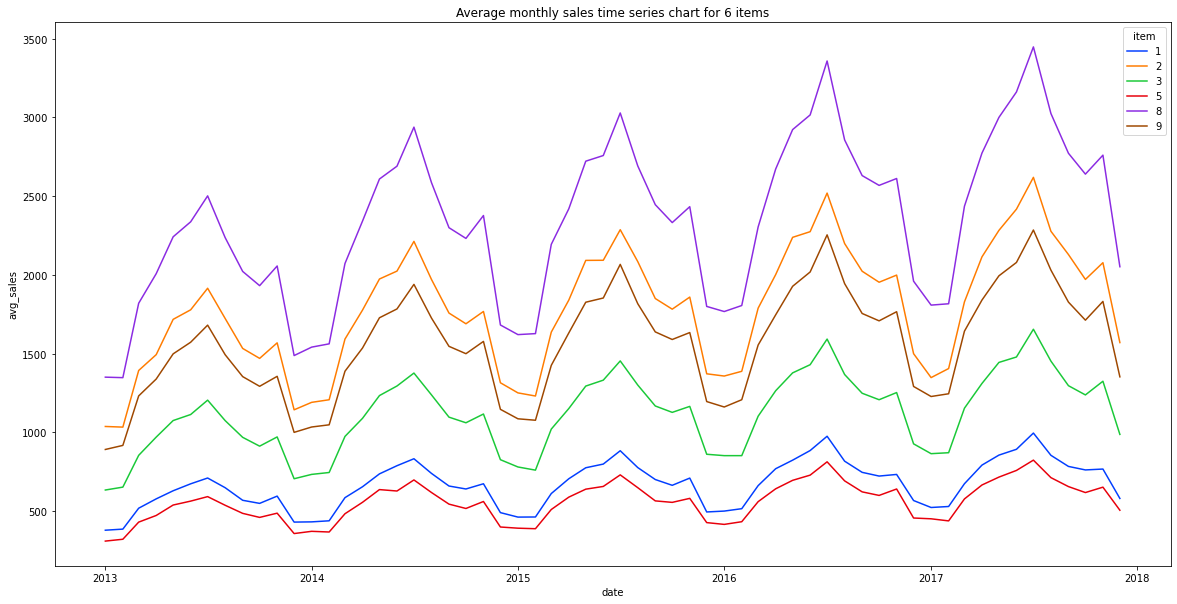

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=avg_monthly_sales_6_items, x="date", y="avg_sales", hue="item",palette='bright')
plt.title('Average monthly sales time series chart for 6 items')

From the above graph it can be clearly understood that the sales for all 6 items are seasonal across each year and has a slightly increasing trend

Hence we can go for Seasonal ARIMA model for forecasting

#### Choosing one item for further testing and model building

In [20]:
# separating 6 items from the dataset for further analysis since all items follow more or less the similar pattern
pdts={'item1':1,'item2':2, 'item3':3, 'item4':5, 'item5':8, 'item6':9}
d={}
for key in pdts:  
    d[key] = pd.DataFrame()
for name,itemset in d.items():
    d[name]=avg_monthly_sales_6_items.loc[avg_monthly_sales_6_items['item']==pdts[name]]
    d[name].drop(columns=['item'],inplace=True)
    d[name]=d[name].set_index('date')
    #print(d[name].head(2))

### Testing for stationarity

In [21]:
#H0/ Null hypothesis: It is non stationary
#H1/ Alternate hypothesis: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("There is strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("There is weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [22]:
#considering 6 items sales
for name,itemset in d.items():
    print("\n\033[1m ADFuller test for stationarity of ",name)
    adfuller_test(itemset['avg_sales'])


 ADFuller test for stationarity of  item1
ADF Test Statistic : -4.926311641554751
p-value : 3.098679702840348e-05
#Lags Used : 11
Number of Observations Used : 48
There is strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary

 ADFuller test for stationarity of  item2
ADF Test Statistic : -4.922935281776459
p-value : 3.146126197356853e-05
#Lags Used : 11
Number of Observations Used : 48
There is strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary

 ADFuller test for stationarity of  item3
ADF Test Statistic : -5.438134858192033
p-value : 2.815394935874281e-06
#Lags Used : 11
Number of Observations Used : 48
There is strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary

 ADFuller test for stationarity of  item4
ADF Test Statistic : -3.952404637665807
p-value : 0.001681298856297218
#Lags Used : 11


Here we can see that the data is stationary for all 6 products

From the previous file(https://github.com/Sonali07Ranjan/Sales-prediction-based-on-historical-data/blob/main/SARIMA_model_based_forecasting.ipynb) based on grid search it was observed that the lowest AIC value of 10.0 was obatined for trend and orders of (1,1,2)x(0,1,1,12) respectively

### Train-Test split and fitting the SARIMA model to train dataset

In [23]:
def train_test(df):
    ''' 
        Sets train and test data for period of prediction     
                         
        df          Dataframe to create split   
    '''

    #Set training data before 2017
    train = df[:'2016-06']
    #Set test data starting 2017
    test = df['2016-07':]
#     plt.plot(train,label='Train')
#     plt.plot(test,label='Test')
#     plt.title('Dataset split for training and testing purpose')
    return train, test

def model_fit(df,pdq,pdqs):
    ''' 
        Performs SARAMA model given defined pdq/s values and returns results     
        
        df          Dataframe to Analyse   
        
        Returns train/test df on the same df modelled   
    '''

    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs, enforce_stationarity=False, 
                                        enforce_invertibility=False)
    results = model.fit()
    results.summary
    print(results.summary().tables[1])
    #results.plot_diagnostics(figsize=(14,10))
    #plt.show();
    return train, test, results,model


 item1
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5845      1.289     -0.453      0.650      -3.111       1.942
ma.L1         -0.1530      1.192     -0.128      0.898      -2.489       2.183
ma.L2         -0.1556      0.888     -0.175      0.861      -1.895       1.584
ma.S.L12      -0.2069      0.228     -0.906      0.365      -0.655       0.241
sigma2       325.1102    183.951      1.767      0.077     -35.428     685.648
RMSE for item1  : 39.73

 item2
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3883      0.410     -0.948      0.343      -1.191       0.415
ma.L1          0.2587   5393.025    4.8e-05      1.000   -1.06e+04    1.06e+04
ma.L2         -0.7413   3998.093     -0.000      1.000   -7836.861    7835.378
ma.S.L12    

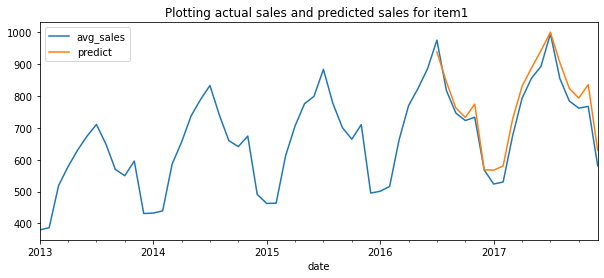

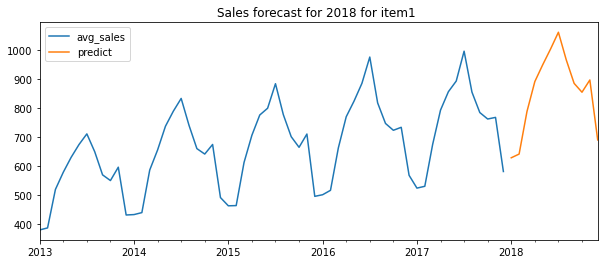

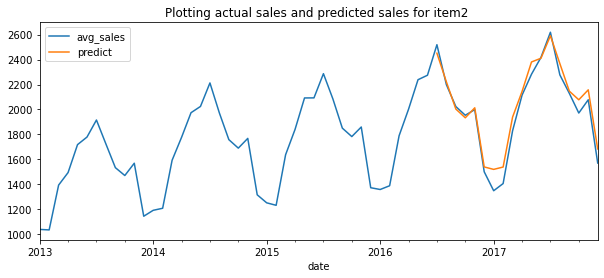

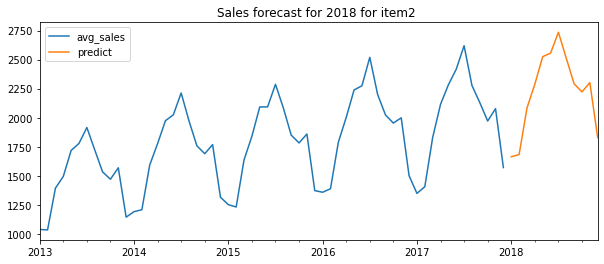

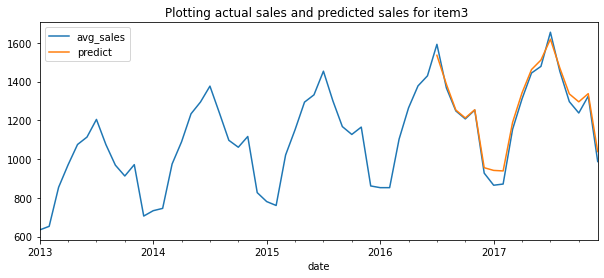

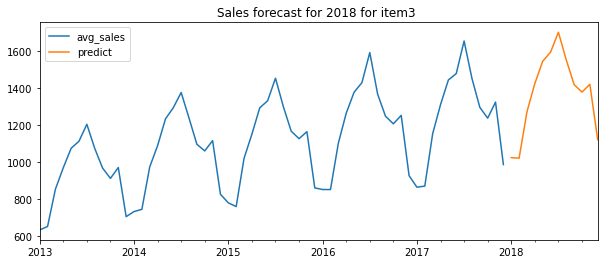

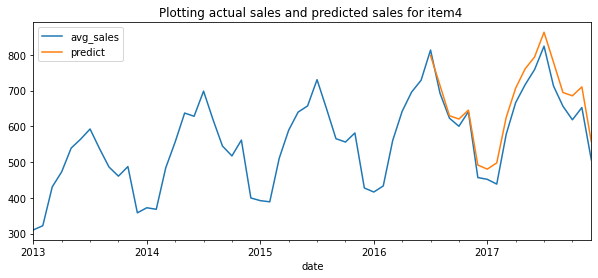

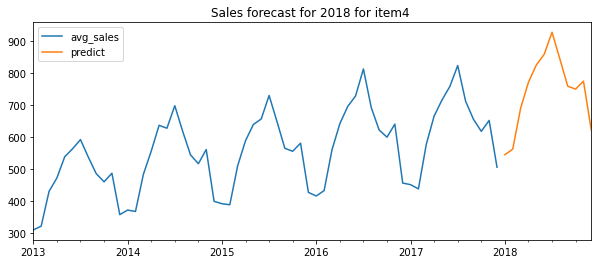

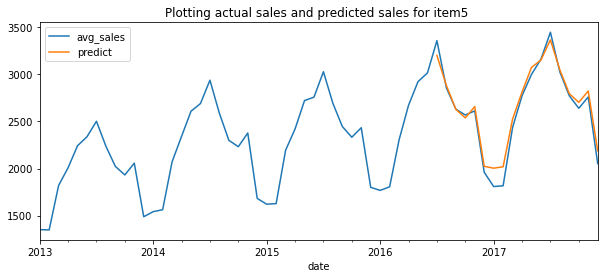

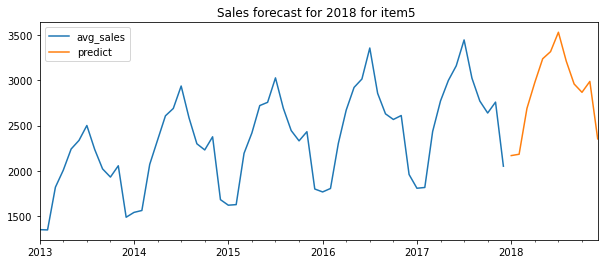

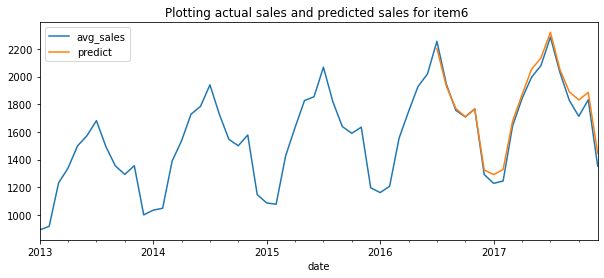

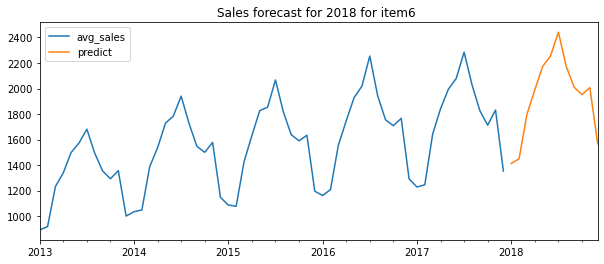

In [24]:
# Optimum values based on grid search with least aic is chosen to train the model
pdq = (1,1,2)
pdqs = (0,1,1,12)
for name,itemset in d.items():
    print("\n",'\033[1m'+name+'\033[0m')
    train, test, results, model = model_fit(itemset,pdq=pdq,pdqs=pdqs)
    itemset['predict']=results.predict(start=42,end=60,dynamic=True)
    itemset[['avg_sales','predict']].plot(figsize=(10,4),title='Plotting actual sales and predicted sales for {} '.format(name))
    #finding RMSE value
    actual_val = itemset.avg_sales[42:]
    predicted_val = itemset.predict[42:]
    rmse = mean_squared_error(actual_val, predicted_val, squared = False)
    print('RMSE for {}  : {}'.format(name,round(rmse,2)))
    # setting the dates for future sales forecast for 12 months
    future_dates=[itemset.index[-1]+ DateOffset(months=x)for x in range(0,13)]
    future_datest_df=pd.DataFrame(index=future_dates[1:],columns=itemset.columns)
    future_df=pd.concat([itemset,future_datest_df])
    future_df['predict'] = results.predict(start=60,end=72, dynamic= True)
    d[name]=future_df.copy()
    d[name].loc['2018-01-01':]['avg_sales']=d[name].loc['2018-01-01':]['predict']
    future_df[['avg_sales', 'predict']].plot(figsize=(10,4),title='Sales forecast for 2018 for {} '.format(name))

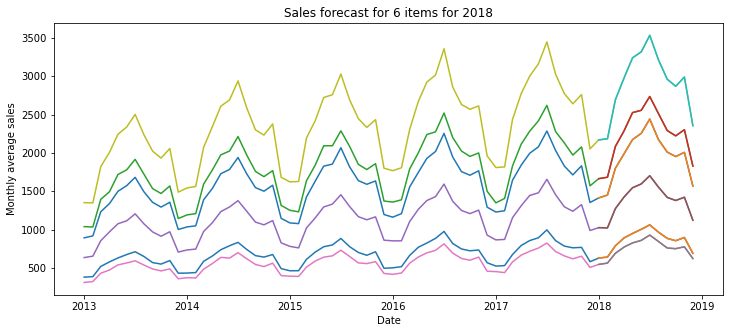

In [25]:
#Plotting the sales forecast for 6 items for 2018
fig=plt.figure(figsize=(12,5))
plt.title('Sales forecast for 6 items for 2018')
plt.xlabel('Date')
plt.ylabel('Monthly average sales')
for name,itemset in d.items():
    plt.plot(d[name])